In [2]:
import os
import random
import tensorflow as tf
import matplotlib.image  as mpimg
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, \
    ReduceLROnPlateau, TensorBoard
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from shutil import copyfile


from sklearn.metrics import classification_report, confusion_matrix

MODEL_DIR = '../models'
LOG_DIR = '../logs'


SIZE = 150, 150

In [2]:
def walk(dir_name):
    names = []
    for dirpath, dirnames, filenames in os.walk(dir_name):
        for filename in filenames:
            names.append(os.path.join(dirpath, filename))
    return names

def image_array(filenames, size):
    result = []
    for filename in filenames:
        image = Image.open(filename)
        image = image.resize(SIZE, Image.ANTIALIAS)
        image_array = np.asarray(image).astype('float32')
        image_array = image_array[:, :, :] / 255
        del image
        result.append(image_array)
    return result


## CallBacks

In [3]:
tensorboard_logs = TensorBoard(log_dir=LOG_DIR, histogram_freq=1,
                               write_graph=False, write_images=True,
                               write_grads=True,
                               update_freq='epoch')
mcp_save = ModelCheckpoint(os.path.join(MODEL_DIR, 
                                        'modelweights.{epoch:02d}-{val_loss:.2f}.hdf5'),
                           save_best_only=True, monitor='val_loss', mode='min')
early_stop = EarlyStopping(monitor='val_loss', patience=4, verbose=0, mode='min')
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=2,
                              verbose=1, min_delta=1e-2, mode='min')


W0614 13:45:06.318048 140675666253568 callbacks.py:1191] `write_grads` will be ignored in TensorFlow 2.0 for the `TensorBoard` Callback.


In [6]:
caminho_bases = os.path.join('..', 'bases', 'vazios')
caminho_train = os.path.join(caminho_bases, 'train')
caminho_test = os.path.join(caminho_bases, 'test')



In [4]:
def make_dirs(lista):
    for caminho in lista:
        print(caminho)
        if not os.path.exists(caminho):
            os.mkdir(caminho)
make_dirs([caminho_train, caminho_test])
for classe in ['vazio', 'nvazio']:
    make_dirs([os.path.join(caminho_train, classe),
                os.path.join(caminho_test, classe)])

../bases/vazios/train
../bases/vazios/test
../bases/vazios/train/vazio
../bases/vazios/test/vazio
../bases/vazios/train/nvazio
../bases/vazios/test/nvazio


In [5]:
def split_data(source, train, test, SPLIT_SIZE=.9):
    files = []
    for filename in os.listdir(source):
        file = os.path.join(source, filename)
        if os.path.getsize(file) > 0:
            files.append(filename)
        else:
            print(filename + " is zero length, so ignoring.")

    training_length = int(len(files) * SPLIT_SIZE)
    testing_length = int(len(files) - training_length)
    shuffled_set = random.sample(files, len(files))
    training_set = shuffled_set[0:training_length]
    testing_set = shuffled_set[:testing_length]

    for filename in training_set:
        this_file = os.path.join(source, filename)
        destination = os.path.join(train, filename)
        copyfile(this_file, destination)

    for filename in testing_set:
        this_file = os.path.join(source, filename)
        destination = os.path.join(test, filename)
        copyfile(this_file, destination)


VAZIO_SOURCE_DIR = os.path.join(caminho_bases, 'vazio')
TRAIN_VAZIO_DIR = os.path.join(caminho_train, 'vazio')
TEST_VAZIO_DIR = os.path.join(caminho_test, 'vazio')
NVAZIO_SOURCE_DIR = os.path.join(caminho_bases, 'nvazio')
TRAIN_NVAZIO_DIR = os.path.join(caminho_train, 'nvazio')
TEST_NVAZIO_DIR = os.path.join(caminho_test, 'nvazio')

In [7]:
split_data(VAZIO_SOURCE_DIR, TRAIN_VAZIO_DIR, TEST_VAZIO_DIR)
split_data(NVAZIO_SOURCE_DIR, TRAIN_NVAZIO_DIR, TEST_NVAZIO_DIR)

In [6]:
for split in os.listdir(caminho_bases):
    caminho_split = os.path.join(caminho_bases, split)
    if os.path.isdir(caminho_split):
        for categoria in os.listdir(caminho_split):
            caminho_total = os.path.join(caminho_bases, split, categoria)
            if os.path.isdir(caminho_total):
                print(split, categoria, len(os.listdir(caminho_total)))


train nvazio 10494
train vazio 10351
test nvazio 1166
test vazio 1151
test_semdificeis nvazio 1000
test_semdificeis vazio 1000
train_semdificeis nvazio 9063
train_semdificeis vazio 10502


(496, 203)


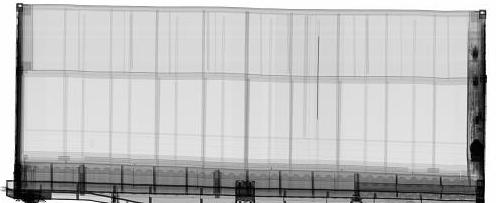

In [7]:
from PIL import Image
from random import sample
SAMPLE_VAZIO = sample(os.listdir(TRAIN_VAZIO_DIR), 1)[0]
img_vazio = Image.open(os.path.join(TRAIN_VAZIO_DIR, SAMPLE_VAZIO))
print(img_vazio.size)
img_vazio

(398, 207)


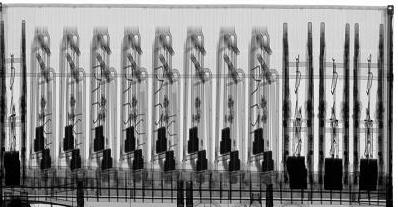

In [8]:
from PIL import Image
from random import sample
SAMPLE_NVAZIO = sample(os.listdir(TRAIN_NVAZIO_DIR), 1)[0]
img_nvazio = Image.open(os.path.join(TRAIN_NVAZIO_DIR, SAMPLE_NVAZIO))
print(img_nvazio.size)
img_nvazio

In [7]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    width_shift_range=0.1,
    height_shift_range=0.1,
    brightness_range=[0.8, 1.2],
    fill_mode='nearest',
    horizontal_flip=True,
)
train_generator = train_datagen.flow_from_directory(
    caminho_train,
    target_size=(150, 150),
    batch_size=64,
    class_mode='binary'
)

validation_datagen = ImageDataGenerator(
    rescale=1./255,
    width_shift_range=0.1,
    height_shift_range=0.1,
    brightness_range=[0.8, 1.2],
    fill_mode='nearest',
    horizontal_flip=True,
)

validation_generator = train_datagen.flow_from_directory(
    caminho_test,
    target_size=(150, 150),
    batch_size=16,
    class_mode='binary'
)

Found 20845 images belonging to 2 classes.
Found 2317 images belonging to 2 classes.


In [12]:
model = tf.keras.models.Sequential([
  tf.keras.layers.Conv2D(16, (3, 3), activation='relu', input_shape=(150, 150, 3)),
  MaxPooling2D(pool_size=(2, 2)),
  Dropout(0.25),
  Conv2D(32, (3, 3), activation='relu'),
  MaxPooling2D(pool_size=(2, 2)),
  Dropout(0.25),
  Conv2D(64, (3, 3), activation='relu'),
  MaxPooling2D(pool_size=(2, 2)),
  Dropout(0.25),
  Conv2D(128, (3, 3), activation='relu'),
  Conv2D(128, (1, 1), activation='relu'),
  MaxPooling2D(pool_size=(2, 2)),
  Conv2D(256, (3, 3), activation='relu'),
  Conv2D(512, (1, 1), activation='relu'),
  Flatten(),
  Dense(512, activation='relu'),
  Dropout(0.2),
  Dense(1, activation='sigmoid')
 
])

model.compile(optimizer=RMSprop(lr=0.001), loss='binary_crossentropy', metrics=['acc'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 148, 148, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 74, 74, 16)        0         
_________________________________________________________________
dropout (Dropout)            (None, 74, 74, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 72, 72, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 36, 36, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 36, 36, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 34, 34, 64)        1

In [32]:
history = model.fit_generator(train_generator,
                              epochs=20,
                              verbose=1,
                              callbacks=[early_stop, mcp_save, reduce_lr, tensorboard_logs],
                              validation_data=validation_generator)

W0521 11:22:15.351036 140634507245312 callbacks.py:1443] `epsilon` argument is deprecated and will be removed, use `min_delta` instead.


Epoch 1/20
282/282 [==============================] - 79s 281ms/step - loss: 0.2836 - acc: 0.9409 - val_loss: 0.5045 - val_acc: 0.5000
Epoch 2/20
282/282 [==============================] - 80s 282ms/step - loss: 0.0504 - acc: 0.9836 - val_loss: 0.1144 - val_acc: 0.9650
Epoch 3/20
282/282 [==============================] - 73s 260ms/step - loss: 0.2673 - acc: 0.9844 - val_loss: 0.3107 - val_acc: 0.9965
Epoch 4/20
282/282 [==============================] - 67s 238ms/step - loss: 0.0696 - acc: 0.9897 - val_loss: 0.0731 - val_acc: 0.9835
Epoch 5/20
282/282 [==============================] - 63s 223ms/step - loss: 0.0204 - acc: 0.9949 - val_loss: 0.0194 - val_acc: 0.9920
Epoch 6/20
282/282 [==============================] - 62s 221ms/step - loss: 0.2458 - acc: 0.9922 - val_loss: 0.0477 - val_acc: 0.9840
Epoch 7/20
282/282 [==============================] - 62s 220ms/step - loss: 0.0331 - acc: 0.9940 - val_loss: 0.0669 - val_acc: 0.9760


In [3]:
model2 = tf.keras.models.Sequential([
  tf.keras.layers.Conv2D(16, (3, 3), activation='relu', input_shape=(150, 150, 3)),
  MaxPooling2D(pool_size=(2, 2)),
  Dropout(0.25),
  Conv2D(64, (3, 3), activation='relu'),
  MaxPooling2D(pool_size=(2, 2)),
  Dropout(0.25),
  Conv2D(128, (3, 3), activation='relu'),
  MaxPooling2D(pool_size=(2, 2)),
  Dropout(0.25),
  Conv2D(256, (3, 3), activation='relu'),
  MaxPooling2D(pool_size=(2, 2)),
  Dropout(0.25),
  Conv2D(256, (3, 3), activation='relu'),
  Dropout(0.25),
  GlobalAveragePooling2D(),
  Dense(256, activation='relu'),
  Dropout(0.2),
  Dense(1, activation='sigmoid')
 
])

model2.compile(optimizer=RMSprop(lr=0.001), loss='binary_crossentropy', metrics=['acc'])
model2.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 148, 148, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 74, 74, 16)        0         
_________________________________________________________________
dropout (Dropout)            (None, 74, 74, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 72, 72, 64)        9280      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 34, 34, 128)       7

# O Kernel pode ser reiniciado e o modelo recarregado diretamente pela linha abaixo, para fazer avaliação e visualização

In [4]:
epoch = 18
val_loss = 0.15
model2.load_weights(
    os.path.join(MODEL_DIR,
                 'model2weights.{:02d}-{:.2f}.hdf5'.format(epoch, val_loss)
                ))

In [12]:
mcp_save2 = ModelCheckpoint(
    os.path.join(MODEL_DIR, 'model2weights.{epoch:02d}-{val_loss:.2f}.hdf5'),
    save_best_only=True, monitor='val_loss', mode='min'
)

history = model2.fit_generator(train_generator,
                               initial_epoch=epoch,
                              epochs=30,
                              verbose=1,
                              callbacks=[early_stop, mcp_save2, reduce_lr],
                              validation_data=validation_generator)

Epoch 14/30
326/326 [==============================] - 296s 907ms/step - loss: 0.3252 - acc: 0.9451 - val_loss: 0.1666 - val_acc: 0.9504
Epoch 15/30
326/326 [==============================] - 126s 386ms/step - loss: 0.2496 - acc: 0.9474 - val_loss: 0.1877 - val_acc: 0.9409
Epoch 16/30
325/326 [============================>.] - ETA: 0s - loss: 0.1750 - acc: 0.9483
Epoch 00016: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
326/326 [==============================] - 123s 379ms/step - loss: 0.1752 - acc: 0.9482 - val_loss: 0.1711 - val_acc: 0.9530
Epoch 17/30
326/326 [==============================] - 129s 395ms/step - loss: 0.1562 - acc: 0.9540 - val_loss: 0.1525 - val_acc: 0.9555
Epoch 18/30
326/326 [==============================] - 123s 378ms/step - loss: 0.1540 - acc: 0.9549 - val_loss: 0.1466 - val_acc: 0.9555
Epoch 19/30
325/326 [============================>.] - ETA: 0s - loss: 0.1530 - acc: 0.9551
Epoch 00019: ReduceLROnPlateau reducing learning rate to 1.000

<Figure size 432x288 with 0 Axes>

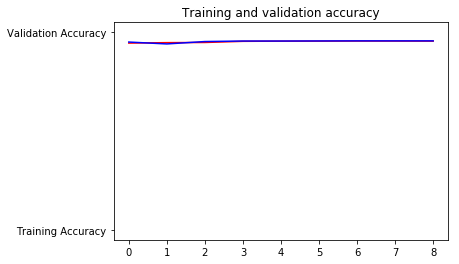

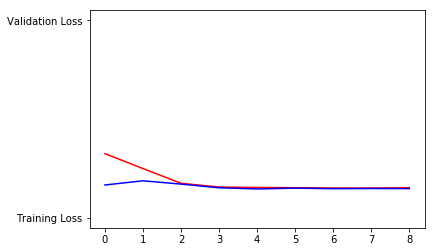

<Figure size 432x288 with 0 Axes>

In [13]:
%matplotlib inline
#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
acc=history.history['acc']
val_acc=history.history['val_acc']
loss=history.history['loss']
val_loss=history.history['val_loss']

epochs=range(len(acc)) # Get number of epochs

#------------------------------------------------
# Plot training and validation accuracy per epoch
#------------------------------------------------
plt.plot(epochs, acc, 'r', "Training Accuracy")
plt.plot(epochs, val_acc, 'b', "Validation Accuracy")
plt.title('Training and validation accuracy')
plt.figure()

#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot(epochs, loss, 'r', "Training Loss")
plt.plot(epochs, val_loss, 'b', "Validation Loss")
plt.figure()


In [10]:
y_test = []
y_pred = []
X_error_test = []
for r in range(len(validation_generator)):
    X, y = next(validation_generator)
    y_test.extend(y)
    y_pred_ = model2.predict_on_batch(X)
    for ind, (y_, y_true) in enumerate(zip(y_pred_, y_test)):
            
        if y_ > 0.5:
            y__ = 1.
        else:
            y__ = 0.
        y_pred.append(y__)
        if y__ != y_true:
            X_error_test.append(X[ind])


In [11]:
print(len(y_test))

2317


In [12]:
print(len(y_pred))

2317


In [13]:
del X
del y

In [18]:
import sys
sys.getsizeof(y_test)

19264

In [14]:
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

[[1061  105]
 [   0 1151]]
              precision    recall  f1-score   support

         0.0       1.00      0.91      0.95      1166
         1.0       0.92      1.00      0.96      1151

    accuracy                           0.95      2317
   macro avg       0.96      0.95      0.95      2317
weighted avg       0.96      0.95      0.95      2317



In [20]:
lista_erros = list(np.nonzero(np.array(y_test) != np.array(y_pred))[0])

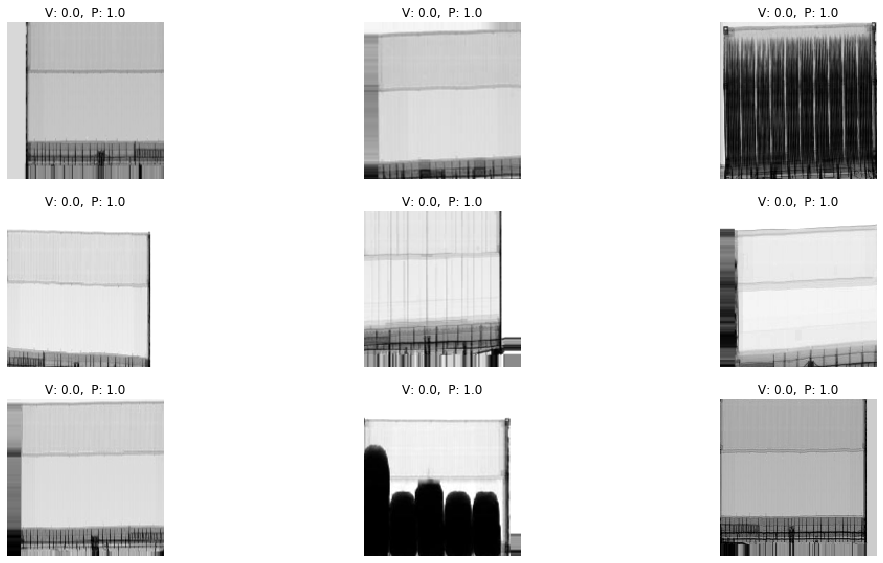

In [60]:
fig, ax = plt.subplots(3, 3, figsize=(15, 8))
plt.tight_layout()
for num_img in range(9):
    axe = ax[num_img // 3, num_img % 3]
    ind = random.randint(1, len(lista_erros) - 1)
    choice = lista_erros[ind]
    text = 'V: %s,  P: %s' % (y_test[choice], y_pred[choice])
    axe.axis('off')
    axe.axes.get_xaxis().set_visible(False)
    axe.axes.get_yaxis().set_visible(False)
    axe.imshow(X_error_test[ind])
    axe.set_title(text)
    

In [21]:
X_error = []
y_train = []
y_pred_train = []
for r in range(len(train_generator)):
    X, y = next(train_generator)
    y_train.extend(y)
    y_pred_train_ = model2.predict_on_batch(X)
    for ind, (y_, y_true) in enumerate(zip(y_pred_train_, y)):
        if y_ > 0.5:
            y__ = 1.
        else:
            y__ = 0.
        y_pred_train.append(y__)
        if y__ != y_true:
            X_error.append(X[ind])


In [22]:
print(confusion_matrix(y_train, y_pred_train))
print(classification_report(y_train, y_pred_train))

[[ 9559   935]
 [    6 10345]]
              precision    recall  f1-score   support

         0.0       1.00      0.91      0.95     10494
         1.0       0.92      1.00      0.96     10351

    accuracy                           0.95     20845
   macro avg       0.96      0.96      0.95     20845
weighted avg       0.96      0.95      0.95     20845



In [36]:
erros = np.nonzero(np.array(y_train) != np.array(y_pred_train))

In [41]:
lista_erros = erros[0]

In [42]:
len(X_error)

941

Verdadeiro: 0.0,  Predição: 1.0


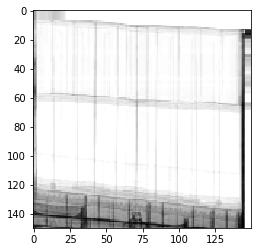

In [73]:
ind = random.randint(1, len(lista_erros) - 1)
choice = lista_erros[ind]
print('Verdadeiro: %s,  Predição: %s' % (y_train[choice], y_pred_train[choice]))
plt.imshow(X_error[ind])

In [62]:
activation_model = tf.keras.Model(inputs=model2.input,
                                  outputs=model2.get_layer('global_average_pooling2d').output)

(256,)


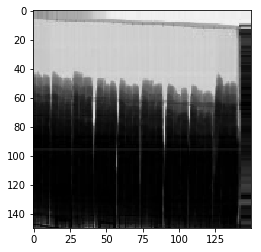

In [80]:
test_image, _ = next(train_generator)
activations = activation_model.predict(np.expand_dims(test_image[0], axis =0))
print(activations[0].shape)
plt.imshow(test_image[0])

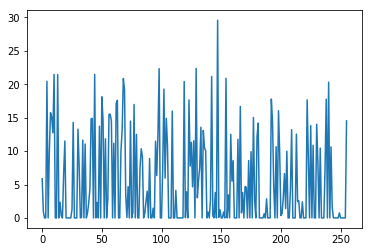

In [81]:
plt.plot(activations[0])

In [82]:
def show_activations(layer_name, image):
    activation_model = tf.keras.Model(inputs=model2.input,
                                  outputs=model2.get_layer(layer_name).output)
    activations = activation_model.predict(np.expand_dims(image, axis=0))
    rows = cols = int(activations[0].shape[2] ** 0.5)
    print(rows, cols)
    fig, axes = plt.subplots(rows, cols, figsize=(10,10))
    for r in range(rows * cols):
        axes[r % rows, r // cols].imshow(activations[0][:, :, r])

8 8


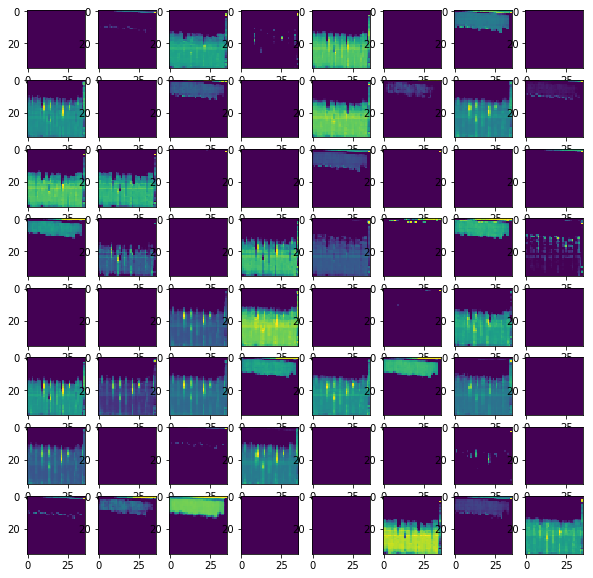

In [83]:
show_activations('max_pooling2d_1', test_image[0])

11 11


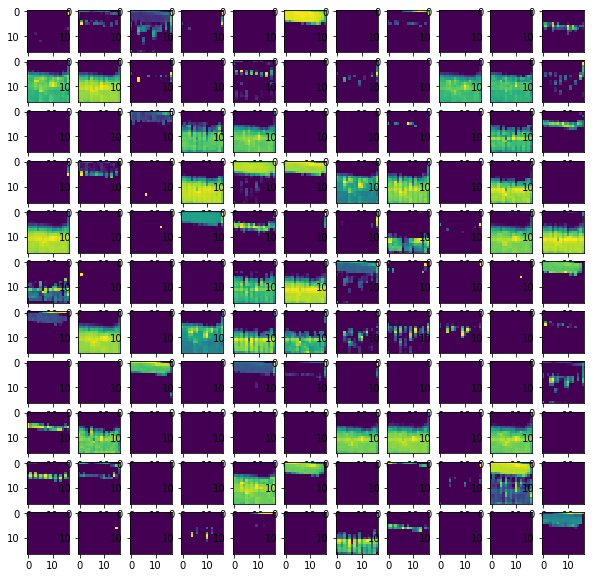

In [84]:
show_activations('max_pooling2d_2', test_image[0])

16 16


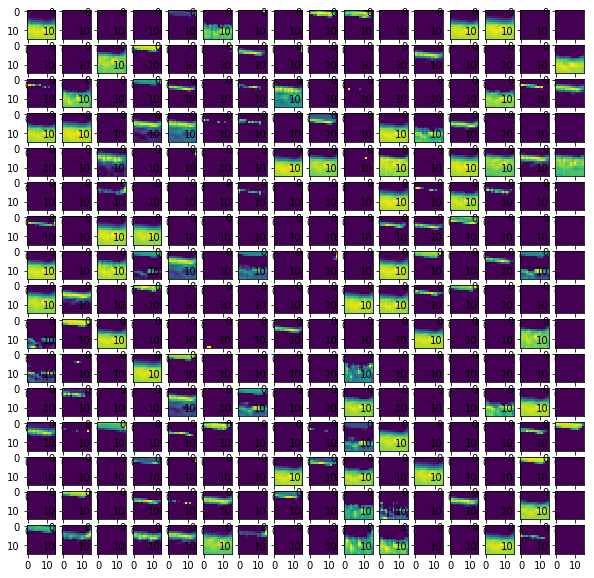

In [85]:
show_activations('conv2d_3', test_image[0])